In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
import cmasher as cmr

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in the data cubes
from spectral_cube import SpectralCube
from astropy.nddata.utils import Cutout2D

IR_cube = fits.open('../ngc253/muse/data/NGC_0253_I_IRAC_8.0_d2009.fits')

# this is just resizing the IR data to zoom in on the galaxy; don't worry about it
x0 = 1800
x1 = 2450
y0 = 2000
y1 = 2650
center = ((x1 + x0)/2, (y1 + y0)/2)
new_shape = (y1-y0, x1-x0)
IR_cube_cutout = Cutout2D(IR_cube[0].data, center, size=new_shape, wcs=wcs.WCS(IR_cube[0].header))

# take a random channel in the middle and mask the edges
south_cube = SpectralCube.read('../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits', hdu=1)
south_cube_wcs = south_cube[0,:,:].wcs
south_cube_mom0 = south_cube[1800,:,:].to_value()  # moment 0
nan_mask_south = np.isfinite(south_cube_mom0).astype(float)  # boolean array

north_cube = SpectralCube.read('../ngc253/muse/data/ADP.2019-08-24T09_53_08.548.fits', hdu=1)
north_cube_wcs = north_cube[0,:,:].wcs
north_cube_mom0 = north_cube[1800,:,:].to_value()  # moment 0
nan_mask_north = np.isfinite(north_cube_mom0).astype(float)  # boolean array

# reproject the mask into the footprint of the IR image
nan_mask_reproj_south, footprint = reproject_interp((nan_mask_south, south_cube_wcs), IR_cube_cutout.wcs, shape_out=new_shape)
nan_mask_reproj_north, footprint = reproject_interp((nan_mask_north, north_cube_wcs), IR_cube_cutout.wcs, shape_out=new_shape)

# get the extent
pixscale = IR_cube[0].header['PXSCAL2']  # arcsec/pixel
x_south_lower = -(new_shape[1]*pixscale)//2
x_south_upper = (new_shape[1]*pixscale)//2
y_south_lower = -(new_shape[0]*pixscale)//2
y_south_upper = (new_shape[0]*pixscale)//2
extent_IR=[x_south_lower,x_south_upper, y_south_lower,y_south_upper]

In [3]:
Afont = {
        'family' : 'courier new',
        'weight': 'bold',
        'size': 14,
        }

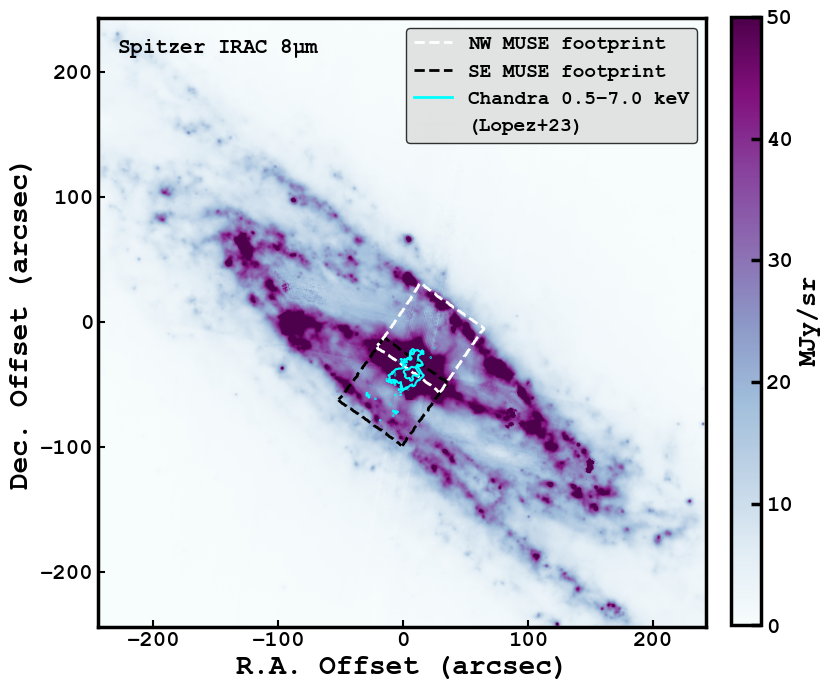

In [4]:
cmap='BuPu'
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(1,1,1)
im = ax.imshow(IR_cube_cutout.data, vmin=0, vmax=50, cmap=cmap, origin='lower',extent=extent_IR)

# contour the mask to just get the edges
ax.contour(nan_mask_reproj_south, levels=[0.5], lws=0.5, colors='black', linewidths=2, 
           linestyles='--', labels='SE', extent=extent_IR)
ax.contour(nan_mask_reproj_north, levels=[0.5], lws=0.5, colors='white', linewidths=2, 
           linestyles='--', labels='NW', extent=extent_IR)

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='black')
ax.set_xlabel('R.A. Offset (arcsec)', fontsize=20)
ax.set_ylabel('Dec. Offset (arcsec)', fontsize=20)

# add a color bar
cax = ax.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('MJy/sr', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

at = AnchoredText('Spitzer IRAC 8$\mu$m', prop=dict(size=15), frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

Xray = fits.open('../ngc253/muse/data/ngc253_chandra_diffuse.fits')
Xray_array, _ = reproject_interp(Xray, IR_cube_cutout.wcs, shape_out=new_shape)
Xray_cont = ax.contour(Xray_array, levels=[9, 55, 311], colors='cyan', extent=extent_IR)


from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
scalebar = AnchoredSizeBar(ax.transData,
                           5.14, '1 kpc', 'lower center', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1)

custom_lines = [Line2D([0], [0], color='white', lw=2, ls='--'),
                Line2D([0], [0], color='black', lw=2, ls='--'),
                Line2D([0], [0], color='cyan', lw=2, ls='-'),
                Line2D([0], [0], color='gainsboro', alpha=0.1,lw=2, ls='-')]
    
plt.legend(custom_lines,['NW MUSE footprint', 'SE MUSE footprint', 'Chandra 0.5–7.0 keV', '(Lopez+23)'], fontsize=14, 
                        loc='upper right', facecolor='gainsboro', edgecolor='black')

plt.tight_layout()
# plt.savefig('../ngc253/muse/visuals/footprints.png', bbox_inches='tight',dpi=200)

plt.show()